### Abstract

* Computers are good at answering questions with single verifiable answers. For Example, querying “Who is the Prime Minister of India?” on google, will give a perfect answer. When it comes to answering subjective aspects of a question, Humans do a much better job than what computers do. Few subjective aspects include 
    * *Is the question understandable?*
    * *Is the question conversational?*
    * *Is the answer to the question understandable?*
* The CrowdSource team at Google Research, has collected data on a number of these subjective aspects for each question-answer pair. Crowdsource gathers your feedback, and feedback from others around the world, which helps the machine to learn from accurate examples and improves the services provided by google like Maps, Translate etc. 

* The question-answer pairs were gathered from nearly 70 different websites. The raters received minimal guidance and training, and relied largely on their intelligence to answer subjective aspects of the prompts. As such, each prompt was simplified in such a way so that raters could simply use their common-sense to complete the task.

* The task here is to build a predictive algorithm which would quantify these subjective aspects given a question-answer pair.
* **Evaluation Metric** - The Evaluation Metric for this competition is *Spearman Rank Correlation Coefficient*. The Spearman's rank correlation is computed for each target column, and the mean of these values is calculated for the submission score. 

### This Notebook is aimed to understand and gain insights from the data using Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as snb
import warnings
import matplotlib.pyplot as plt
import re
import string
from gensim.models import KeyedVectors
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
'''
This cell outputs basic information about the dataset such as number of columns/column names.
'''
print(f"Number of examples in train data : {train_df.shape[0]}")
print("Inputs of train data:")
print(train_df.columns[:11])
print("\n#############################################################################################\n")
print(f"Number of examples in test data : {test_df.shape[0]}")
print("Inputs of test data:")
print(test_df.columns[:11])
print("\n#############################################################################################\n")
target_cols = train_df.columns[11:]
print(f"Number of target variables : {len(target_cols)}")
print("target variables : ")
print(target_cols)

Number of examples in train data : 6079
Inputs of train data:
Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

#############################################################################################

Number of examples in test data : 476
Inputs of test data:
Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

#############################################################################################

Number of target variables : 30
target variables : 
Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
      

### Brief on the Input columns

* qa_id - id assigned to each example 
* question_title - Summary of a specific problem. Smaller in length than the question_body. Question Title is an eye catcher
* question_body - Details more on the specific problem.
* answer - Answer/Solution to a given question
* url - url of the example
* category - category of the example
* question_user_name - Name of the user who asked the question
* answer_user_name - Name of the user who answered the question.

### Analysis on Domain 

In [5]:
'''
Here, from the host we extract domains. For example, both "stackexchange.com" and
"eli.stackexchange" has stackexchange and eli as domain respectively
'''

train_df['domain'] = train_df.host.apply(lambda s:s.split('.')[0])
print(f"Total number of unique domains in train data : {train_df['domain'].unique().shape[0]}")
      
test_df['domain'] = test_df.host.apply(lambda s:s.split('.')[0])
print(f"Total number of  unique domains in test data : {test_df['domain'].unique().shape[0]}")

s1 = set(train_df['domain'].unique())
s2 = set(test_df['domain'].unique())
s = s1.union(s2)
print(f"Total number of unique domains in train + test data : {len(s)}")

Total number of unique domains in train data : 59
Total number of  unique domains in test data : 53
Total number of unique domains in train + test data : 59


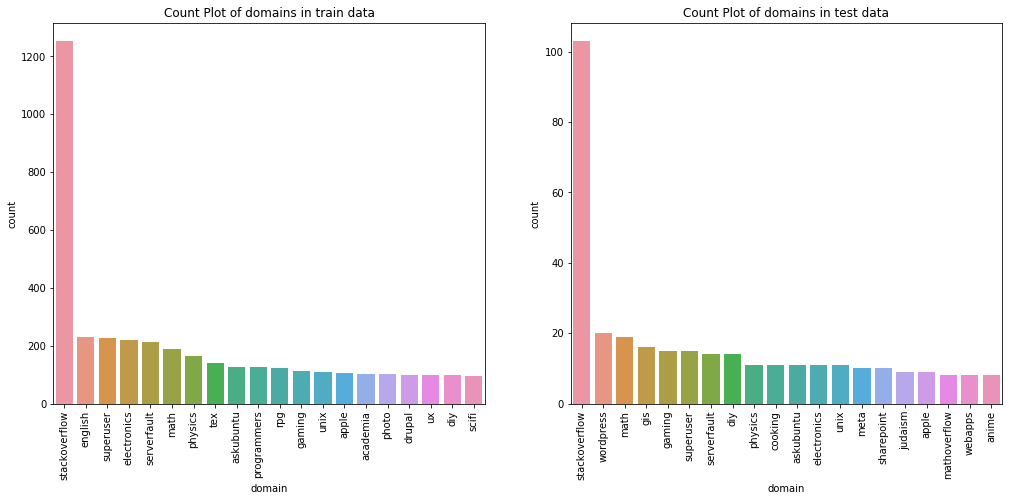

In [6]:
'''Plot for distribution of domains in train and test data'''
ax = plt.subplots(1, 2, figsize = (17, 7))[-1]
dframes = [train_df, test_df]
name = ['train', 'test']
for i in range(2):
    snb.countplot(x = 'domain', data = dframes[i], ax = ax[i], 
                  order = dframes[i]['domain'].value_counts().index[:20])
    ax[i].set_title(f'Count Plot of domains in {name[i]} data') 
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
plt.show()

#### Observation
* Large number of examples are fetched from stackoverflow domain
* The distribution of domains in both train and test data are different.

### Analysis on Categories 

In [7]:
'''
This cell computes total number of categories in train + test data
'''
s1 = set(train_df['category'].unique())
s2 = set(test_df['category'].unique())
s = s1.union(s2)
print(f"Total number of unique categories in train + test data : {len(s)}")

Total number of unique categories in train + test data : 5


In [37]:
target_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

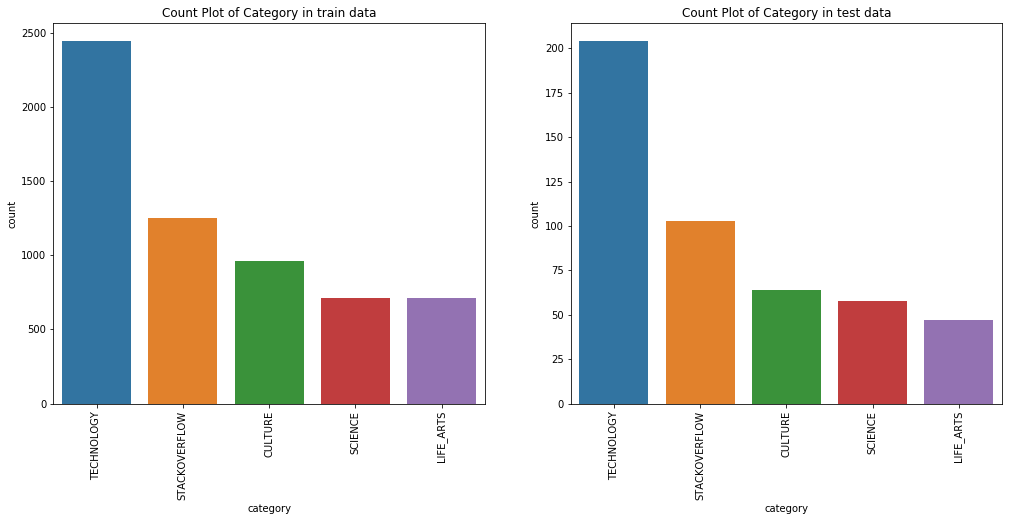

In [8]:
'''Plot for distribution of categories in train and test data'''
ax = plt.subplots(1, 2, figsize = (17, 7))[-1]
for i in range(2):
    snb.countplot(x = 'category', data = dframes[i], ax = ax[i], 
                  order = dframes[i]['category'].value_counts().index)
    ax[i].set_title(f'Count Plot of Category in {name[i]} data') 
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
plt.show()

#### Observation
* Distribution of categories in train and test data are similar

### Analysis on targets

In [9]:
'''This cell shows the discrete nature of target variables. Left of the arrow represent the target name,
right of the arrow represent unique values of the target'''
for i in range(len(target_cols)):
    print(f"{target_cols[i]} -------------> {train_df[target_cols[i]].unique()}\n")
    

question_asker_intent_understanding -------------> [1.         0.88888889 0.83333333 0.77777778 0.66666667 0.55555556
 0.33333333 0.44444444 0.5       ]

question_body_critical -------------> [0.33333333 1.         0.66666667 0.77777778 0.44444444 0.55555556
 0.88888889 0.5        0.83333333]

question_conversational -------------> [0.         0.66666667 0.33333333 0.5        1.        ]

question_expect_short_answer -------------> [0.         0.5        1.         0.33333333 0.66666667]

question_fact_seeking -------------> [0.         1.         0.33333333 0.66666667 0.5       ]

question_has_commonly_accepted_answer -------------> [0.         1.         0.66666667 0.5        0.33333333]

question_interestingness_others -------------> [1.         0.44444444 0.66666667 0.88888889 0.77777778 0.55555556
 0.5        0.33333333 0.83333333]

question_interestingness_self -------------> [1.         0.44444444 0.66666667 0.33333333 0.77777778 0.55555556
 0.88888889 0.5        0.83333333]

qu

In [10]:
'''Fetch URL's of which question_type_spelling > 0'''
train_df.url[train_df.question_type_spelling > 0] 

362     http://english.stackexchange.com/questions/269...
700     http://english.stackexchange.com/questions/333...
930     http://ell.stackexchange.com/questions/58002/i...
1259    http://english.stackexchange.com/questions/220...
1561    http://english.stackexchange.com/questions/111...
1628    http://english.stackexchange.com/questions/220...
1646    http://english.stackexchange.com/questions/307...
2591    http://english.stackexchange.com/questions/333...
3323    http://ell.stackexchange.com/questions/14327/i...
3579    http://english.stackexchange.com/questions/642...
4082    http://english.stackexchange.com/questions/269...
Name: url, dtype: object

#### Observations
* Each target label is discrete in nature. Values are in [0, 1]
* The above cell confirms that the target 'question_type_spelling' > 0 if url has 'ell.stackexchange' or 'english.stackexchange' as domain.

### Text Preprocessing & Analysis

* Before analysis of text or modelling ML models on text, it is essential to preprocess your text data. This is because, unprocessed text hides a lot of information. For example, if you simply tokenize the sentence : 'However, there were many challanges.", tokens of this text will be ['However,', 'there', 'were', 'many','challanges.']. ['there', 'were', 'many'] are valid english words and will be in the vocabulary, but ['However,', 'challanges.'] will not be in the vocabulary even though they are valid english words. Hence, we need to preprocess text data to minimize such situations and leverage information better.

* reference - https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

In [11]:
'''Some contractions, rules and token replace dictionaries which will help in text preprocessing'''
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"its":"it is",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

rules = {
    "'t": " not",
    "'cause": " because",
    "'ve": " have",
    "'t": " not",
    "'s": " is",
    "'d": " had"
}

punctuations = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", 
                '$', '&', '/', '[', ']','>', '%', '=', '#', '*', '+', '\\', '•', '~', 
                '@', '£', '·', '_', '{', '}', '©', '^','®', '`', '<', '→', '°', '€', '™', 
                '›', '♥', '←', '×', '§', '″', '′', 'Â', '█','½', 'à', '…', '“', '★', '”', 
                '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶','↑', '±', '¿', '▾', '═', 
                '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼','⊕', '▼', '▪', '†',
                '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲','è', '¸', '¾', 
                'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪','╩', 
                '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 
                'ï', 'Ø', '¹', '≤', '‡', '√'] + list(string.punctuation)
token_replace = {
    'usepackage':'latex',
    'orf19':'gene',
    'documentclass':'latex',
    'magento':'open-source e-commerce',
    'appium':'web-app',
    'tikz':'programming language',
    'tikzpicture':'programming language',
    'openvpn':'vpn',
    'httpclient':'http client',
    'arraylist':'array list',
    'jsonobject': 'json',
    'artifactid':'xml',
    'hwnd':'os'
    
}

In [36]:
'''Load fasttext word embeddings'''
vectors = KeyedVectors.load_word2vec_format('fasttext-wiki-news-subwords-300.gz')

KeyboardInterrupt: 

In [13]:
'''Pipeline for text preprocessing. Check coverage computes what %age of tokens in the text data 
are covered by Embeddings.
preprocess_text is used to clean text.
'''
def improve_text(dframes):
    def build_vocab(texts):
        vocab = {}
        for text in texts:
            for word in text.split():
                try:
                    vocab[word] += 1
                except:
                    vocab[word] = 1
        return vocab
    def check_coverage(texts):
        present = []
        oov = []
        in_embeddings = 0
        not_in_embeddings = 0
        total = 0
        for text in texts:
            for word in text.split():
                if word in vectors:
                    present += [word]
                    in_embeddings += 1
                else:
                    oov += [word]
                    not_in_embeddings += 1
                total += 1
        print(re.sub('\s+', ' ',f"{np.round(100*in_embeddings/total, 3)}% of the tokens in the text (train + test)\
        are covered by Embeddings"))
        return Counter(oov)
    def preprocess_text(s):
        s = s.lower()
        '''Expanding contractions...'''
        for key, value in contractions.items():
            s = s.replace(key, f' {value} ')
        for key, value in rules.items():
            s = s.replace(key, f' {value} ')
        '''Fixing punctuations...'''
        for punct in punctuations:
            if punct in vectors:
                s = s.replace(punct, f' {punct} ')
            else:
                s = s.replace(punct, ' ')
        '''Replacing few tokens with its similar word/group of words...'''
        for key, value in token_replace.items():
            s = s.replace(key, value)
        '''Removing HTML tags'''
        s = re.sub('<.*?>', ' ', s)
        s = re.sub('\s+', ' ', s)
        return s
    
    def get_texts(c1 = 'question_title', c2='question_body', c3='answer'):
        all_texts = []
        for each_df in dframes:
            all_texts += each_df[c1].tolist() + each_df[c2].tolist() + \
            each_df[c3].tolist()
        return all_texts
    all_texts = get_texts()
    vocab = Counter(build_vocab(all_texts))
    oov = check_coverage(all_texts)
    print("Top 100 most frequent out-of-vocabulary")
    print(oov.most_common(100))
    print("Applying Preprocessing.....")
    for each_df in dframes:
        each_df['clean_title'] = each_df['question_title'].apply(preprocess_text)
        each_df['clean_question_body'] = each_df['question_body'].apply(preprocess_text)
        each_df['clean_answer'] = each_df['answer'].apply(preprocess_text)
    print("Preprocessing Finished")
    all_texts = get_texts('clean_title', 'clean_question_body', 'clean_answer')
    vocab = Counter(build_vocab(all_texts))
    oov = check_coverage(all_texts)
    print("Top 100 most frequent out-of-vocabulary")
    print(oov.most_common(100))

In [14]:
improve_text([train_df, test_df])

82.085% of the tokens in the text (train + test) are covered by Embeddings
Top 100 most frequent out-of-vocabulary
[("I'm", 2919), ("don't", 2302), ("it's", 1827), ("I've", 1380), ('//', 1349), ("doesn't", 1215), ('&amp;', 1075), ("can't", 1024), ('=&gt;', 899), ('However,', 780), ("you're", 751), ("I'd", 651), ('==', 642), ('example,', 623), ("It's", 613), ('it,', 613), ('this:', 591), ('&gt;', 582), ('(or', 538), ('-&gt;', 530), ("isn't", 528), ("that's", 484), (');', 481), ('So,', 460), ("didn't", 453), ('&lt;', 450), ("won't", 439), ('(and', 423), ('$$', 412), ('this?', 410), ('is,', 399), ('0;', 399), ('0,', 391), ("there's", 383), ('});', 382), ('this,', 365), ('that,', 351), ('(which', 324), ('(the', 323), ("you'll", 304), ('is:', 303), ('/&gt;', 301), ('(I', 300), ('case,', 296), ('&lt;&lt;', 292), ('&lt;?php', 285), ('1,', 283), ('Also,', 281), ('*/', 280), ('&lt;div', 264), ('2,', 261), ('?&gt;', 260), ('it?', 259), ('time,', 257), ('!=', 246), ('\\\\', 245), ("I'll", 241), (

#### Observation
* From the final OOV, we can conclude that majority of tokens come under a programming language syntax. For example, float64, blength, tablecell, varchar2 etc. Such tokens don't have predefined embeddings. We can use finetuing to obtain embeddings for such tokens.

* Below analysis are done in processed text.

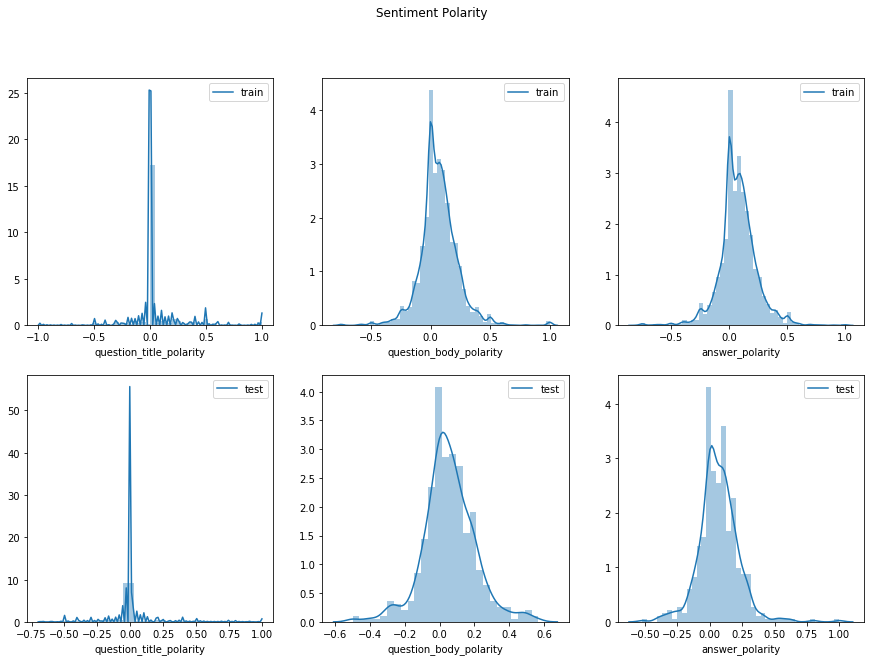

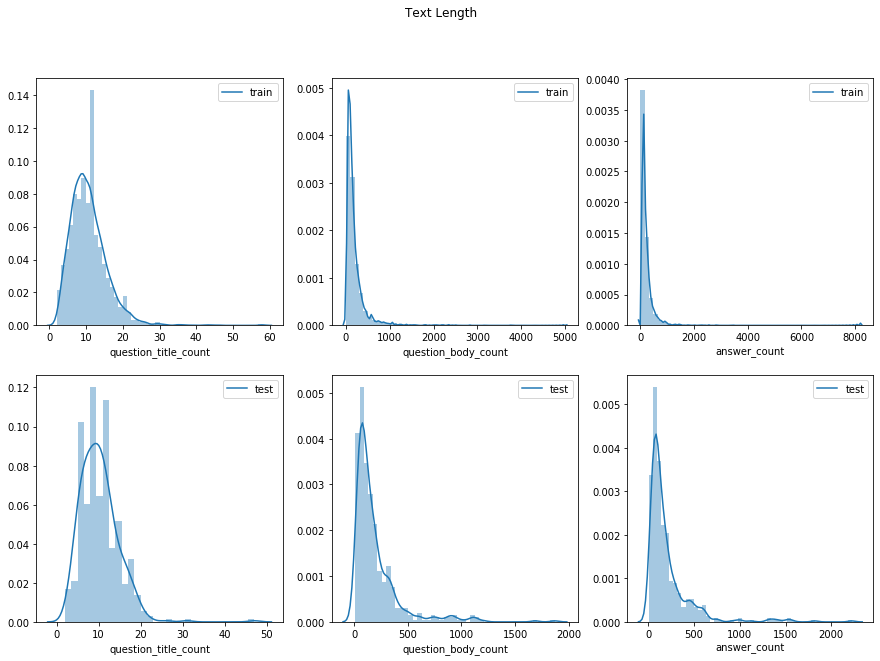

In [15]:
def get_polarity(s):
    return TextBlob(s).sentiment.polarity

train_df['question_title_polarity'] = train_df.clean_title.apply(get_polarity)
train_df['question_body_polarity'] = train_df.clean_question_body.apply(get_polarity)
train_df['answer_polarity'] = train_df.clean_answer.apply(get_polarity)
test_df['question_title_polarity'] = test_df.clean_title.apply(get_polarity)
test_df['question_body_polarity'] = test_df.clean_question_body.apply(get_polarity)
test_df['answer_polarity'] = test_df.clean_answer.apply(get_polarity)
##################################################################################################################
train_df['question_title_count'] = train_df.clean_title.apply(lambda x: len(x.split()))
train_df['question_body_count'] = train_df.clean_question_body.apply(lambda x: len(x.split()))
train_df['answer_count'] = train_df.clean_answer.apply(lambda x: len(x.split()))
test_df['question_title_count'] = test_df.clean_title.apply(lambda x: len(x.split()))
test_df['question_body_count'] = test_df.clean_question_body.apply(lambda x: len(x.split()))
test_df['answer_count'] = test_df.clean_answer.apply(lambda x: len(x.split()))

axes = plt.subplots(2, 3, figsize = (15, 10))
axes[0].suptitle('Sentiment Polarity')
df = [train_df, test_df]
col = ['question_title_polarity', 'question_body_polarity', 'answer_polarity']
for i in range(2):
    for j in range(3):
        snb.distplot(df[i][col[j]], ax = axes[1][i, j], kde_kws = {'label' : ('train' if i == 0 else 'test')})
plt.show()
axes = plt.subplots(2, 3, figsize = (15, 10))
axes[0].suptitle('Text Length')
df = [train_df, test_df]
col = ['question_title_count', 'question_body_count', 'answer_count']
for i in range(2):
    for j in range(3):
        snb.distplot(df[i][col[j]], ax = axes[1][i, j], kde_kws = {'label' : ('train' if i == 0 else 'test'),
                                                                  'cumulative':False})
plt.show()

#### Observation
* Titles in the dataset have nearly 0 polarity. They don't possess positive or negative sentiment.
* Both question_body_count & answer_count look similar to power law distribution. 
* Distribution of Polarities among train and test data are similar.
* Distribution of Text length among train and test data are similar.
* This means that if a model does well in training data, it should work well in test data as well.

### Analysis of Bigrams

In [16]:
train_df['combine_text'] = train_df['clean_title'] + train_df['clean_question_body'] \
+ train_df['clean_answer']
test_df['combine_text'] = test_df['clean_title'] + test_df['clean_question_body'] \
+ test_df['clean_answer']

In [17]:
train_vectorizer = CountVectorizer(ngram_range = (2, 2))
test_vectorizer = CountVectorizer(ngram_range = (2, 2))
train_vectorizer.fit(train_df['combine_text'])
test_vectorizer.fit(test_df['combine_text'])

CountVectorizer(ngram_range=(2, 2))

In [18]:
def count_vocab_freq(sums, vocab_freq, vectorizer):
    sums = sums.A.ravel().tolist()
    features = vectorizer.get_feature_names()
    for index, each in enumerate(sums):
        vocab_freq[features[index]] = each


train_matrix = train_vectorizer.transform(train_df['combine_text'])
test_matrix = test_vectorizer.transform(test_df['combine_text'])

train_vocab_freq = {}
test_vocab_freq = {}

count_vocab_freq(train_matrix.sum(axis = 0), train_vocab_freq, train_vectorizer)
count_vocab_freq(test_matrix.sum(axis = 0), test_vocab_freq, test_vectorizer)

In [21]:
train_vocab_freq = Counter(train_vocab_freq)
test_vocab_freq = Counter(test_vocab_freq)

In [22]:
def most_common_df(most_common):
    words, freq = list(zip(*most_common))
    dictionary = {'words':list(words), 'freq':list(freq)}
    return pd.DataFrame(dictionary)


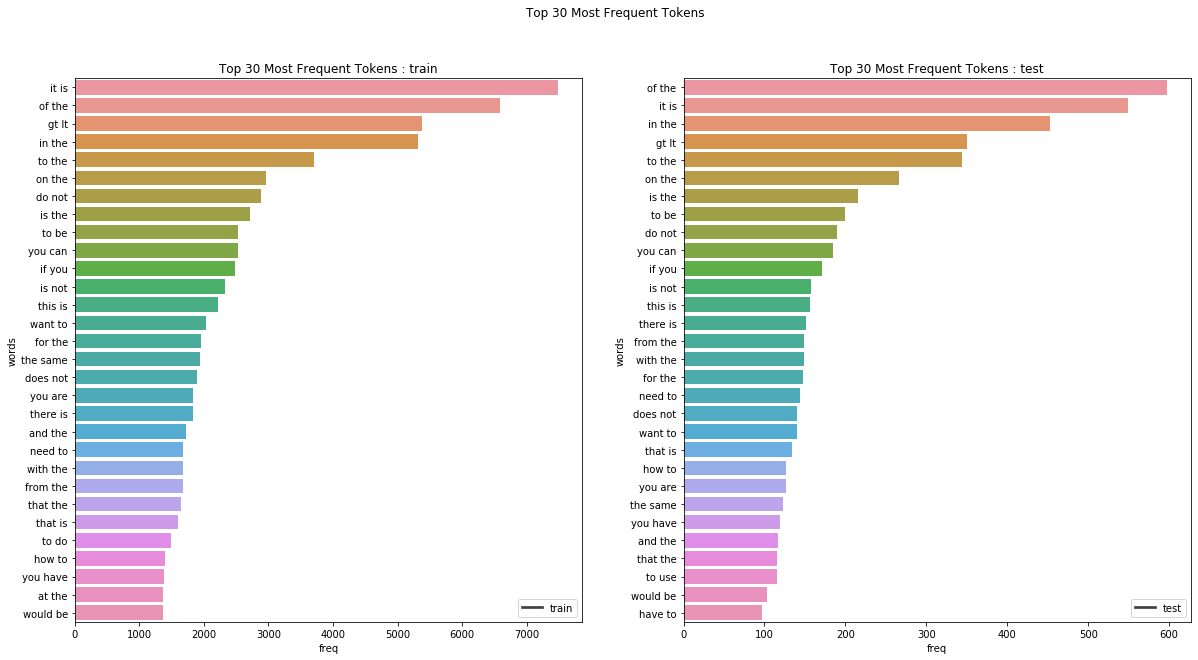

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
fig.suptitle('Top 30 Most Frequent Tokens')
top_most_common = [train_vocab_freq.most_common(30), test_vocab_freq.most_common(30)]
for i in range(len(top_most_common)):
    df = most_common_df(top_most_common[i])
    snb.barplot(x = 'freq', y = 'words', data = df, ax = ax[i])
    ax[i].set_title(f'Top 30 Most Frequent Tokens : {name[i]}')
    ax[i].legend([name[i]], loc = 'lower right')

In [24]:
for top_common in [30, 50, 70, 100, 200, 300, 500]:
    s_train = set(list(zip(*train_vocab_freq.most_common(top_common)))[0])
    s_test = set(list(zip(*train_vocab_freq.most_common(top_common)))[0])
    union_length = len(s_train.union(s_test))
    intersection_length = len(s_train.intersection(s_test))
    print(re.sub('\s+',' ',f"Cardinality of intersection of train top {top_common} frequency bigrams and test top \
    frequency bigrams : {intersection_length}"))
    print(re.sub('\s+',' ',f"Cardinality of union of train top {top_common} frequency bigrams and test top \
    frequency bigrams : {union_length}"))

Cardinality of intersection of train top 30 frequency bigrams and test top frequency bigrams : 30
Cardinality of union of train top 30 frequency bigrams and test top frequency bigrams : 30
Cardinality of intersection of train top 50 frequency bigrams and test top frequency bigrams : 50
Cardinality of union of train top 50 frequency bigrams and test top frequency bigrams : 50
Cardinality of intersection of train top 70 frequency bigrams and test top frequency bigrams : 70
Cardinality of union of train top 70 frequency bigrams and test top frequency bigrams : 70
Cardinality of intersection of train top 100 frequency bigrams and test top frequency bigrams : 100
Cardinality of union of train top 100 frequency bigrams and test top frequency bigrams : 100
Cardinality of intersection of train top 200 frequency bigrams and test top frequency bigrams : 200
Cardinality of union of train top 200 frequency bigrams and test top frequency bigrams : 200
Cardinality of intersection of train top 300 fr

#### Observation
* The cardinality of intersection of top N frequent bigrams in train text and top N frequent bigrams in test text is as close to the cardinality of union of the two sets.

### Feature Engineering

* **Token** - Components of a text which you obtain by splitting up text on spaces.
* **Stopwords** - A stopword is a commonly used word such as ‘a’, ‘an’, ‘the’ etc. Such words are typically removed from the text during preprocessing.
* **Word** - A token which is not a stopword.
    * We can use these definitions to handcraft features. Given a pair of text T1 and T2, 
        * cwc_min = ratio of common_word_count to min(# of T1 words, # of T2 words )* 
        * cwc_max = ratio of common_word_count to max(# of T1 words, # of T2 words)
        * csc_min = ratio of common_stopwords_count to min(# of T1 stopwords, # of T2 stopwords )
        * csc_max = ratio of common_stopwords_count to max(# of T1 stopwords, # of T2 stopwords )
        * ctc_min = ratio of common_token_count to min(# of tokens in T1, # of tokens in T2)
        * ctc_max = ratio of common_token_count to max(# of tokens in T1, # of tokens in T2)
        * word_t1_to_t2_ratio = (# of words in T1) / (# of words in T2) 
        * token_t1_to_t2_ratio = (# of tokens in T1) / (# of tokens in T2)
        * last_word_eq = boolean( T1[-1] == T2[-1] )
        * first_word_eq = boolean( T1[0] == T2[0] )
* **Fuzzywuzzy** - https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    * These features take a pair of text as input and returns the score out of 100 as an output. Internally this library uses SequenceMatcher class to compute %age similarity between pairs of texts. Implementation details are provided in the above link.
    * **Fuzz ratio** - It simply uses SequenceMatcher to compute similarity between pairs of text. The SequenceMatcher outputs the similarity between 0 to 1. This fuzz ratio converts decimals to percentage i.e. 0 to 100. 
    * **Partial Fuzz Ratio** - If the pair of text have different lengths, i.e. smaller string of length m, larger string of length n, this feature computes ratio based on the best m-length substring. Then,   SequenceMatcher is used to compute ratios between the m-length substring and the smaller string. 
    * **Token Ratio** - In this approach, each text is tokenized and these tokens are sorted based on alphabetical order. The SequenceMatcher is then used to compute ratios. 
    * **Token Set Ratio** - The approach is as follows 
      * S1 - Create a set of intersection of tokens between T1 and T2.
      * S2 - Create a set of tokens present in T1 but not in T2
      * S3 - Create a set of tokens present in T2 but not in T1.
      * return  max ( score( S1, S2 ), score( S1, S3 ), score( S2, S3 )). Scores are computed using SequenceMatcher.



In [25]:
def fetch_words(s, use_stopwords = False, ignore_stopwords = False):
    if ignore_stopwords == True:
        return {word for word in s.split() if word not in stop_words}
    elif use_stopwords:
        return {word for word in s.split() if word in stop_words}
    else:
        return set(s.split())
def text_features(row, uss_stopwords, is_token, return_max):
    t1, t2 = None, None
    if uss_stopwords == True:
        t1 = fetch_words(row[0], use_stopwords = True)
        t2 = fetch_words(row[1], use_stopwords = True)
    elif is_token == True:
        t1 = fetch_words(row[0], ignore_stopwords = True)
        t2 = fetch_words(row[1], ignore_stopwords = True)
    else:
        t1 = fetch_words(row[0])
        t2 = fetch_words(row[1])
    if return_max:
        try:
            ans = len(t1.intersection(t2))/max(len(t1), len(t2))
        except:
            return 0
    else:
        try:
            ans = len(t1.intersection(t2))/min(len(t1), len(t2))
        except:
            return 0
    return ans

def get_ratio(row, is_token = False):
    if is_token == True:
        t1 = len(set([word for word in row[0].split() if word not in stop_words]))
        t2 = len(set([word for word in row[1].split() if word not in stop_words]))
    t1 = len(set([word for word in row[0].split()]))
    t2 = len(set([word for word in row[1].split()]))
    try:
        return t1/t2
    except:
        return 0
def get_fuzzy_ratio(row, ratio, partial_ratio, token_sort_ratio, token_set_ratio):
    if ratio:
        return fuzz.ratio(row[0], row[1])/100
    elif partial_ratio:
        return fuzz.partial_ratio(row[0], row[1])/100
    elif token_sort_ratio:
        return fuzz.token_sort_ratio(row[0], row[1])/100
    else:
        return fuzz.token_set_ratio(row[0], row[1])/100

In [31]:
feature_engg_cols = ['cwc_min_title_question_body',
       'cwc_max_title_question_body', 'csc_min_title_question_body',
       'csc_max_title_question_body', 'ctc_min_title_question_body',
       'ctc_max_title_question_body', 'cwc_min_title_answer',
       'cwc_max_title_answer', 'csc_min_title_answer', 'csc_max_title_answer',
       'ctc_min_title_answer', 'ctc_max_title_answer',
       'cwc_min_question_body_answer', 'cwc_max_question_body_answer',
       'csc_min_question_body_answer', 'csc_max_question_body_answer',
       'ctc_min_question_body_answer', 'ctc_max_question_body_answer',
       'word_title_question_body_ratio', 'token_title_question_body_ratio',
       'word_question_body_answer_ratio', 'token_question_body_answer_ratio',
       'word_title_answer_ratio', 'token_title_answer_ratio',
       'ratio_title_question_body', 'partial_ratio_title_question_body',
       'token_sort_ratio_title_question_body',
       'token_set_ratio_title_question_body', 'ratio_question_body_answer',
       'partial_ratio_question_body_answer',
       'token_sort_ratio_question_body_answer',
       'token_set_ratio_question_body_answer', 'ratio_title_answer',
       'partial_ratio_title_answer', 'token_sort_ratio_title_answer',
       'token_set_ratio_title_answer']

In [27]:
##################################        TRAIN        ############################################################

train_df['cwc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
train_df['cwc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
train_df['cwc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))

train_df['word_title_question_body_ratio'] = train_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (False, ))
train_df['token_title_question_body_ratio'] = train_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (True, ))
train_df['word_question_body_answer_ratio'] = train_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (False, ))
train_df['token_question_body_answer_ratio'] = train_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (True, ))
train_df['word_title_answer_ratio'] = train_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (False, ))
train_df['token_title_answer_ratio'] = train_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (True, ))

train_df['ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
train_df['partial_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
train_df['ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False ))
train_df['partial_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
train_df['ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
train_df['partial_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))

##################################        TEST        ############################################################

test_df['cwc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
test_df['cwc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
test_df['cwc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))

test_df['word_title_question_body_ratio'] = test_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (False, ))
test_df['token_title_question_body_ratio'] = test_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (True, ))
test_df['word_question_body_answer_ratio'] = test_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (False, ))
test_df['token_question_body_answer_ratio'] = test_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (True, ))
test_df['word_title_answer_ratio'] = test_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (False, ))
test_df['token_title_answer_ratio'] = test_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (True, ))

test_df['ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
test_df['partial_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
test_df['ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False ))
test_df['partial_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
test_df['ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
test_df['partial_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))

In [34]:
def get_distplots_for_cols(x, y, figsize, suptitle, df, cols):
    fig, axes = plt.subplots(x, y, figsize = figsize)
    fig.suptitle(suptitle, fontsize = 30)
    i, j = 0, 0
    for col in cols:
        if j == y:
            i += 1
            j = 0
        snb.distplot(df[col], ax = axes[i, j])
        axes[i, j].legend([col])
        axes[i, j].set_xlabel('')
        j += 1

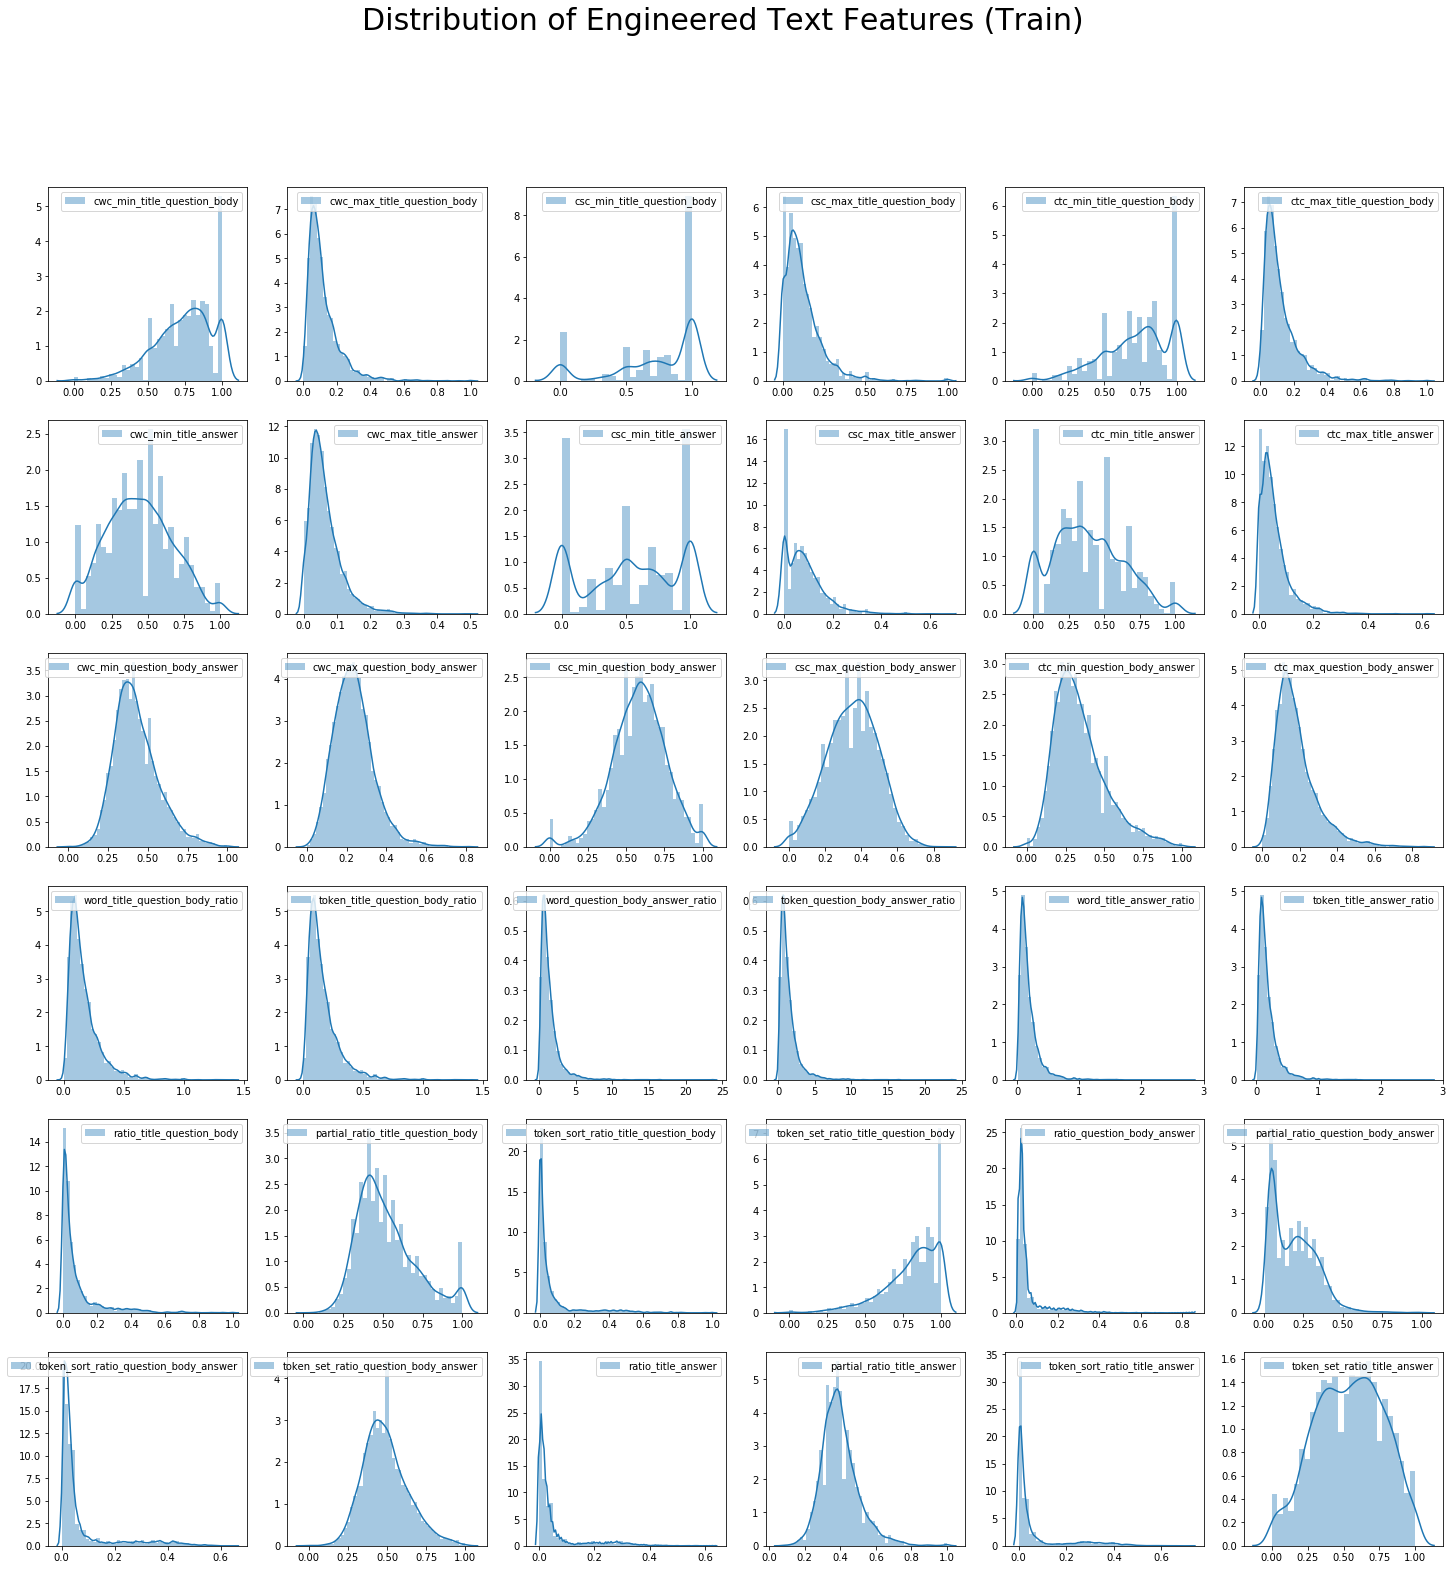

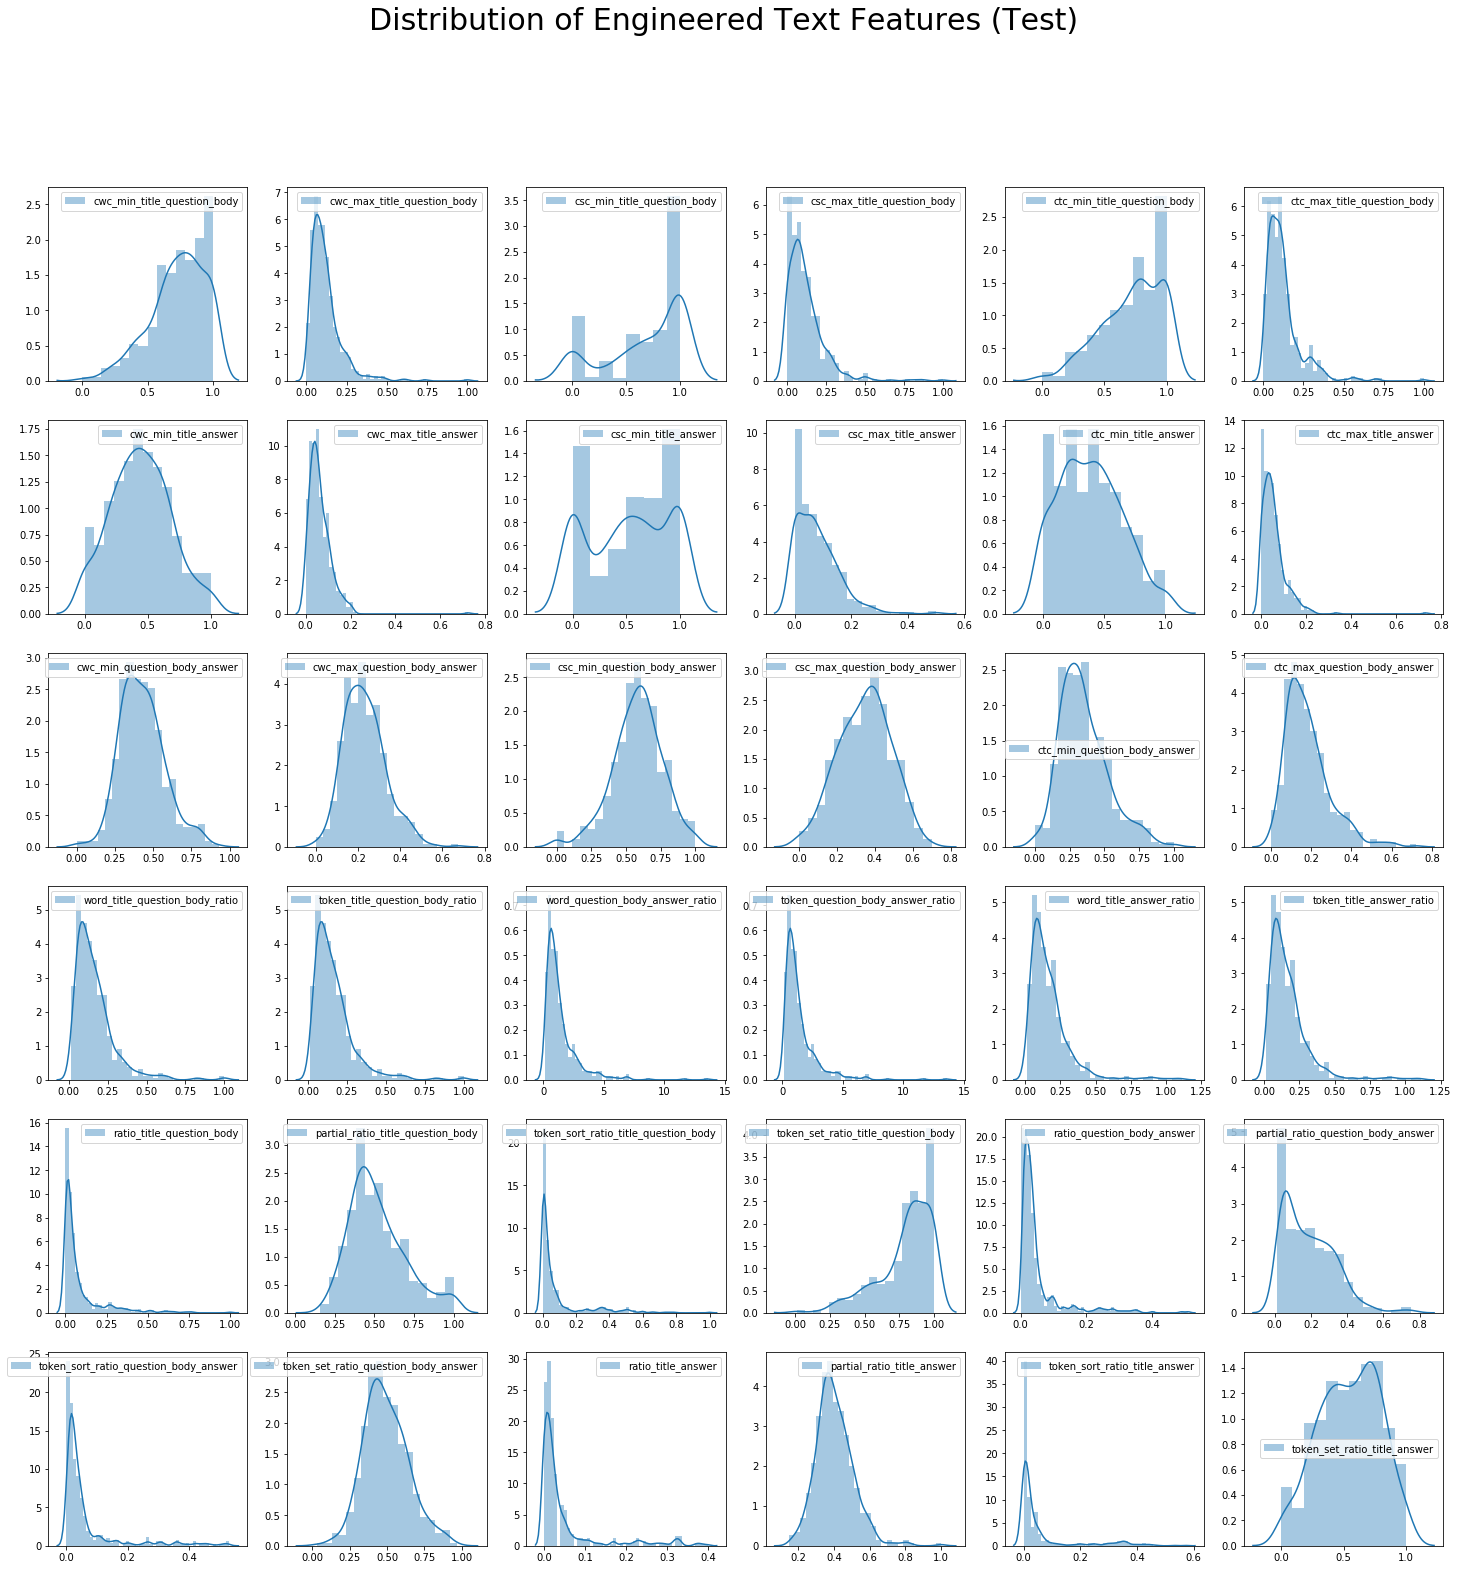

In [35]:
get_distplots_for_cols(6, 6, (25, 25), 'Distribution of Engineered Text Features (Train)', train_df, 
                       feature_engg_cols)
plt.show()
get_distplots_for_cols(6, 6, (25, 25), 'Distribution of Engineered Text Features (Test)', test_df, 
                       feature_engg_cols)
plt.show()

#### Observations
* The distribution of majority of engineered features among train and test data look similar especially the skewness. Hence, we can use these features in Modeling phase. This also means that both train and test data come from similar distribution. 

### Conclusions
* Large number of examples are fetched from stackoverflow domain
* The distribution of domains in both train and test data are different.
* Each target label is discrete in nature. Values are in [0, 1]
* The target 'question_type_spelling' > 0 if url has 'ell.stackexchange' or 'english.stackexchange' as domain.
* From the final OOV, we can conclude that many tokens come under programming language syntax. For example, float64, blength, tablecell, varchar2 etc. Such tokens don't have predefined embeddings. We can use finetuing to obtain embeddings for such tokens.
* The cardinality of intersection of (**top N frequent bigrams in train text**) and (**top N frequent bigrams in test text**) is close to the cardinality of union of the two sets.
* The distribution of majority of engineered features among train and test data look similar. Hence, we can use these features in Modeling phase. This also means that both train and tese come from similar distribution. 